<div style="text-align:right"><i>Peter Norvig<br>May 2023</div>
    
# Wei-Hwa's Diamond-Buying Game 

Wei-Hwa Huang writes: "*You are playing a game where you are trying to buy diamonds with coins.  You can buy a random bag of diamonds for 12 coins, look in the bag, and [immediately] decide whether to sell it back for 11 coins or keep it.  You can also purchase a bag for 1 coin but you **must** sell it back for 1 coin (i.e., you can basically figure out the distribution [by peeking at multiple bags for free]). What is a general strategy for maximizing the number of diamonds you keep (that is, total number of diamonds in bags not sold back)?  Include analysis of end cases (e.g., if you spend your last 12 coins, it is never a good idea to sell the bag back).*

## Strategy

A good strategy starts by peeking at enough 1-coin bags to have a good estimate of the probability distribution of bags. The result of the peeking is a discrete probability distribution: a dict of `{number_of_diamonds: probability}`. I'm assuming that "number of diamonds" is always a non-negative integer. The number of peeks you take will depend on how heavy-tailed you think the distribution might be, and on how much patience you have. 

## Probability Distributions

In [1]:
from typing import *
import functools
import random
import statistics

class ProbDist(Counter):
    """A discrete probability distribution, {item: probability}; sum of probabilities is 1.0"""
    def __init__(self, iterable):
        super().__init__(iterable)
        k = sum(self.values())
        for x in self:
            self[x] /= k
            
def normal(mu=100, sigma=10, k=1_000) -> ProbDist: 
    """Probability distribution formed from k samples from a normal distribution,  
    N(mu, sigma); each sample is rounded to a non-negative integer.""" 
    return ProbDist(max(0, round(random.gauss(mu, sigma))) 
                    for _ in range(k))

assert ProbDist([1, 2, 3, 1]) == {1: 0.5, 2: 0.25, 3: 0.25}

## Maximizing Expected Number of Diamonds

Given a discrete probability distribution, and assuming that our goal is to maximize the expected (average) number of diamonds, one suggestion was to establish a **cutoff point**: any bags over the cutoff would be kept; others would be sold back (except that a bag should be kept if selling it back would not result in enough coins to buy another bag). But is that the best strategy? I don't think so, no matter what the cutoff point.

Rather than try to impose a strategy such as the cutoff-poiint strategy, it is better to go directly to the optimal strategy: the strategy that, in each situation, chooses to keep or sell back based on which action has the highest expected return, assuming the optimal strategy continues to be played.

The function `expectation` returns a function `E` such that `E(c)` returns the expected number of diamonds you can obtain starting with `c` coins, and applying the optimal strategy.

In [2]:
def expectation_fn(p:ProbDist, buy=12, sell=11) -> Callable:
    """Returns a function that will compute the expected number of diamonds, given `coins`.
    This is 0 if you can't afford a bag, or is the weighted average, over all possible bag values, of
    the probability of the bag times the maximum of the expectations of keeping the bag or selling it back."""
    @functools.lru_cache(None)
    def E(coins:int) -> float:
        def keep(bag): return bag + E(coins - buy)
        def sellback(bag): return E(coins - buy + sell)
        if coins < buy:
            return 0
        else:
            return sum(p[bag] * max(keep(bag), sellback(bag)) for bag in p)
    return E

## Examing the Results

Here I define `E` and call `E(121)`. With 121 coins, I can buy ten bags, and return one; the expected result is a little more than 10 times 100:

In [3]:
E = expectation_fn(normal(100, 10))
E(121)

1016.9165738912558

Each run will be slightly different (by about 1%) because the random samples are different, so the probability distribution estimate is different:

In [4]:
E = expectation_fn(normal(100, 10))
E(121)

1018.7010335947339

The expected result for 12 coins is about 100; for 11 coins it is zero.

In [5]:
E(12)

100.53299999999999

In [6]:
E(11)

0

## Visualizing the Results

The number of diamonds should increase with the number of coins, and also with the standard deviation of the distribution. Below is a plot showing this:

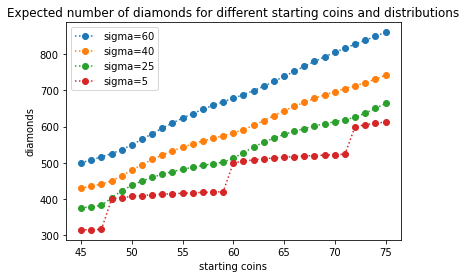

In [7]:
import matplotlib.pyplot as plt

def plot(sigmas=(60, 40, 25, 5), coins=range(45, 76)):
    """Plot the expected number of diamonds for different sigma/starting coins combinations."""
    for sigma in sigmas:
        E = expectation_fn(normal(100, sigma))
        vals = [E(c) for c in coins]
        plt.plot(coins, vals, 'o:', label=f'sigma={sigma}')
        plt.title('Expected number of diamonds for different starting coins and distributions')
        plt.legend(); plt.xlabel('starting coins'); plt.ylabel('diamonds')

plot()

In this plot, the lowest line, corresponding to a standard deviation of 5, has big jumps when we reach 48, 60, and 72 coins, which corresponds to being able to buy 4, 5, and 6 bags. Basically, for standard deviation 5, the strategy with, say, 48 coins is "buy 4 bags, and keep them, no matter what." For distributions with larger standard deviations, the jump is less pronounced, because the strategy with 48 coins is "if we get 4 good bags, then keep them, but if we get a bad bag at the beginning, sell it back and there is a good chance that a careful selection of 3 bags will result in more diamonds than 4 bags that include the bad one."

# Visualizing the Strategy

Now we know how many diamonds to expect from the optimal strategy, but what **is** the optimal strategy? Is it equivalent to, or similar to, the cutoff strategy, for some cutoff? I'll show scatter plots where each dot indicates a situation where the optimal strategy, given a number of coins and a bag value, is to sell the bag back; each empty space means to keep the bag.

In [8]:
def decision_fn(p:ProbDist, buy=12, sell=11) -> Callable:
    """Return a function, fn(coins, bag), that tells whether to keep or sell back the bag."""
    E = expectation_fn(p, buy, sell)
    return lambda coins, bag: (
        'keep' if bag + E(coins - buy) >= E(coins - buy + sell) else 'sellback')

def scatter(p:ProbDist, coins=range(45, 76)):
    """Plot (coins, bag value) points for which the optimal action is to sell back."""
    fn = decision_fn(p)
    XY = [(c, x) for c in coins for x in range(min(p), max(p) + 1) 
          if fn(c, x) == 'sellback']
    plt.scatter(*T(XY), marker='.')
    plt.xlabel('coins'); plt.ylabel('bag value'); 
    plt.title('Combinations of coins / bag value that should be sold back')

def T(matrix): "Transpose"; return zip(*matrix)

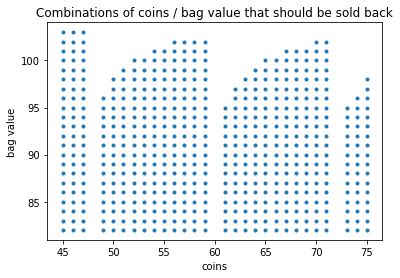

In [9]:
scatter(normal(100, 5))

This shows, for example, that with 48 coins there is no bag value that should be sold back; it is always better to get 4 bags than to sell one back and be left with only 3 bags. But with each extra coin, we can afford to be more picky, and the bag value that we sell back increases, until we get up to 60 coins, where again the best azction is to keep all 5 bags.

However, with a larger standard deviation we get a different scatter plot (there are so many dots they run together to form lines, but that's not important):

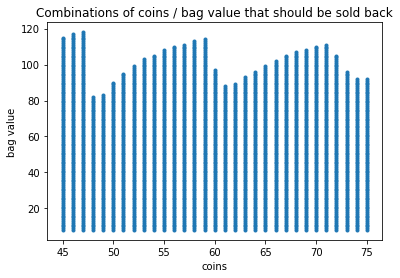

In [10]:
scatter(normal(100, 25))

Let's investigate this more carefully:

In [11]:
p = normal(100, 25)
E = expectation_fn(p)
f = decision_fn(p)

{bag: f(48, bag) for bag in range(78, 88)}

{78: 'sellback',
 79: 'sellback',
 80: 'sellback',
 81: 'sellback',
 82: 'sellback',
 83: 'keep',
 84: 'keep',
 85: 'keep',
 86: 'keep',
 87: 'keep'}

This says that with 48 coins we should sell back a bag of value of 82 or less, even though selling back means we can only get 3 bags instead of 4. The 3 bags will, on average, make up for it, because we can sell back bad ones 11 times. (The exact point at which 'sellback' switches to 'keep' will vary, depending on the samples in the distribution.)

Here we compare the expected values of keeping versus selling back a bag of value 78:

In [12]:
78 + E(36) # What if we kept the bag of value 78, and got 3 other bags (about 100 each) for the 36 other coins?

380.0048248123251

In [13]:
E(47) # What if we sold back the 78-diamond bag, and selected 3 good bags with the remaining 47 coins?

384.36968315108277

We see that selling back is better.